In [54]:
import torch
import torchvision
from torchvision.transforms import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [55]:
# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [56]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [57]:
import torch
#define a suitable architecture for classifying the fashion mnist dataset
import torch.nn as nn

class FashionMNISTClassifier(nn.Module):
    def get_activation_function(self, activation_function: str):
        if activation_function == 'relu':
            return nn.ReLU()
        elif activation_function == 'selu':
            return nn.SELU()
        elif activation_function == 'sigmoid':
            return nn.Sigmoid()

    def __init__(self, activation_function: str):
        super(FashionMNISTClassifier, self).__init__()
        
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            self.get_activation_function(activation_function),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            self.get_activation_function(activation_function),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_stack = nn.Sequential(
            nn.Linear(7*7*32, 128),
            self.get_activation_function(activation_function),
            nn.Linear(128, 10)
        )

        
        
    def forward(self, x):
        #x = x.to(device)
        
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        x = self.linear_stack(x)
        
        return x


In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def eval_model(model: nn.Module) -> float:
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Initialize variables for accuracy calculation
        total = 0
        correct = 0

        # Iterate over the test data
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images).to(device)
            
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the accuracy
        accuracy = correct / total * 100
        print(f"Accuracy: {accuracy:.2f}%")

        # # Plot a random sample of test images with their predicted labels
        # fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        # fig.suptitle("Random Sample of Test Images with Predicted Labels", fontsize=16)
        # axes = axes.flatten()
        # for i in range(10):
        #     image = images[i].squeeze().numpy()
        #     label = predicted[i].item()
        #     axes[i].imshow(image, cmap='gray')
        #     axes[i].set_title(f"Predicted: {label}")
        #     axes[i].axis('off')
        # plt.tight_layout()
        # plt.show()
    return accuracy


In [59]:
import torch.optim as optim
import torch.nn as nn

def train_model(model: nn.Module, optimizer_type: str, batch_size: int, epochs = 1) -> list[float]:
    train_accuracies = []
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define the loss function
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    for epoch in range(epochs):
        # Iterate over the training data
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images).to(device)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the model's parameters
            optimizer.step()
        
        train_accuracies.append(eval_model(model))
        print(f"Finished epoch {epoch + 1}")
        
    return train_accuracies


In [60]:
accuracies = {}
batch_sizes = [1, 10, 100]
optimizers = ['adam', 'sgd']
activation_functions = ['relu', 'selu', 'sigmoid']

def train_for_activation_function(activation_function: str):
    model = FashionMNISTClassifier(activation_function=activation_function).to(device)
    if accuracies.get(activation_function) == None:
        accuracies[activation_function] = {}

    for optimizer in optimizers:
        if accuracies.get(activation_function).get(optimizer) == None:
            accuracies[activation_function][optimizer] = {}

        for batch_size in batch_sizes:
            if accuracies.get(activation_function).get(optimizer).get(batch_size) == None:
                accuracies[activation_function][optimizer][batch_size] = []
            
            train_accuracies = train_model(model, optimizer, batch_size, epochs=10)
            accuracies[activation_function][optimizer][batch_size] = train_accuracies

In [61]:
#RELU
train_for_activation_function('relu')

Accuracy: 86.97%
Finished epoch 1
Accuracy: 88.50%
Finished epoch 2
Accuracy: 89.26%
Finished epoch 3
Accuracy: 89.52%
Finished epoch 4
Accuracy: 88.29%
Finished epoch 5
Accuracy: 89.48%
Finished epoch 6
Accuracy: 88.47%
Finished epoch 7
Accuracy: 87.37%
Finished epoch 8
Accuracy: 89.40%
Finished epoch 9
Accuracy: 88.99%
Finished epoch 10
Accuracy: 90.17%
Finished epoch 1
Accuracy: 90.36%
Finished epoch 2
Accuracy: 90.78%
Finished epoch 3
Accuracy: 90.63%
Finished epoch 4
Accuracy: 90.52%
Finished epoch 5
Accuracy: 90.28%
Finished epoch 6
Accuracy: 90.27%
Finished epoch 7
Accuracy: 90.28%
Finished epoch 8
Accuracy: 90.65%
Finished epoch 9
Accuracy: 90.24%
Finished epoch 10
Accuracy: 90.34%
Finished epoch 1
Accuracy: 90.73%
Finished epoch 2
Accuracy: 90.30%
Finished epoch 3
Accuracy: 90.62%
Finished epoch 4
Accuracy: 90.49%
Finished epoch 5
Accuracy: 90.40%
Finished epoch 6
Accuracy: 90.47%
Finished epoch 7
Accuracy: 90.56%
Finished epoch 8
Accuracy: 90.46%
Finished epoch 9
Accuracy: 90

In [12]:
#SELU
train_for_activation_function('selu')
#SIGMOID
train_for_activation_function('sigmoid')

Finished epoch 1
Accuracy: 87.54%
Finished epoch 1
Accuracy: 89.97%
Finished epoch 1
Accuracy: 91.45%
Finished epoch 1
Accuracy: 90.85%
Finished epoch 1
Accuracy: 91.49%
Finished epoch 1
Accuracy: 91.59%


Finished epoch 1
Accuracy: 84.01%
Finished epoch 1
Accuracy: 87.54%
Finished epoch 1
Accuracy: 88.36%
Finished epoch 1
Accuracy: 88.97%
Finished epoch 1
Accuracy: 89.25%
Finished epoch 1
Accuracy: 89.22%


In [63]:
#save the accuracies in a file
import json
# Specify the file path
file_path = './accuracies.json'

# Convert the accuracies dictionary to a JSON string
accuracies_json = json.dumps(accuracies)

# Write the JSON string to the file
with open(file_path, 'w') as file:
    file.write(accuracies_json)


In [85]:

# plot the accuracies as a 3D line plot
# on the x-axis, we have the batch sizes
# on the y-axis, we have the epochs
# on the z-axis, we have the accuracies
# the different lines represent the different optimizers and activation functions

import pandas as pd

# Load the accuracies from the JSON file
with open(file_path, 'r') as file:
    _accuracies = json.load(file)
    
# store the data in a dataframe
rows = []
for activation_function, activation_function_data in _accuracies.items():
    for optimizer, optimizer_data in activation_function_data.items():
        for batch_size, accuracies in optimizer_data.items():
            for epoch, accuracy in enumerate(accuracies):
                rows.append({
                    'activation_function': activation_function,
                    'optimizer': optimizer,
                    'batch_size': batch_size,
                    'epoch': epoch + 1,
                    'accuracy': accuracy
                })
                
df = pd.DataFrame(rows)
df['batch_size'] = df['batch_size'].astype('int64')
df['epoch'] = df['epoch'].astype('int64')
df['accuracy'] = df['accuracy'].astype('float64')


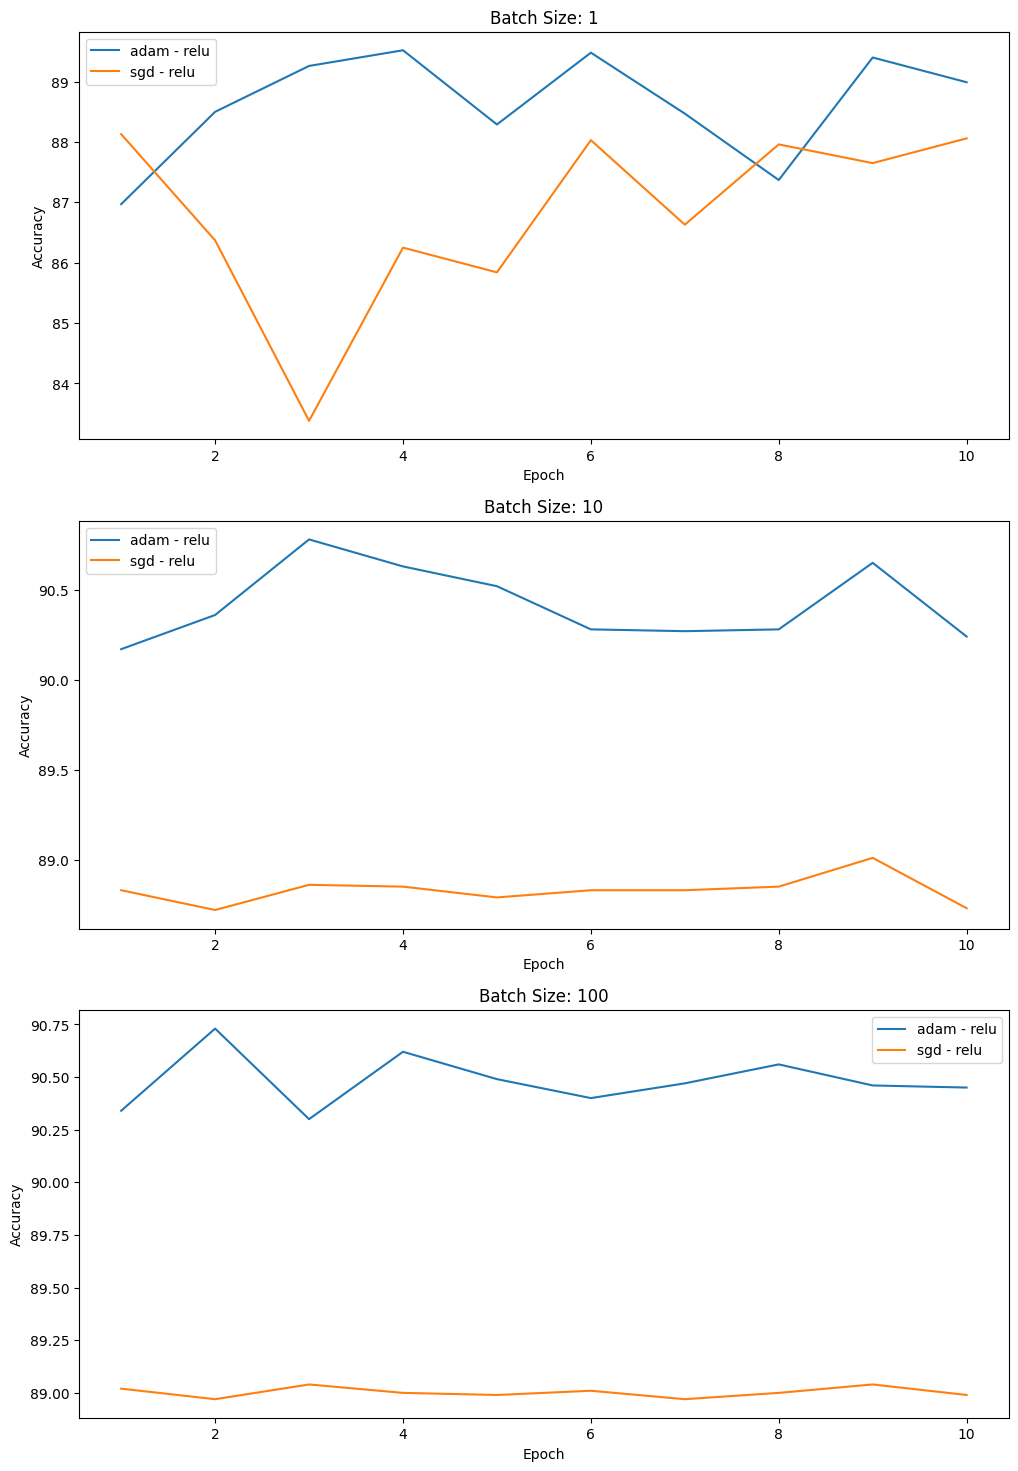

In [101]:
import matplotlib.pyplot as plt

# Plot epochs vs accuracy curve for optimizers and activation function
#create one plot for each batch size
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

plot_index = 0
for batch_size in batch_sizes:
    for optimizer in optimizers:
        for activation_function in activation_functions:
            df_subset = df[(df['optimizer'] == optimizer) & (df['activation_function'] == activation_function) & (df['batch_size'] == batch_size)]
            axs[plot_index].plot(df_subset['epoch'], df_subset['accuracy'], label=f'{optimizer} - {activation_function}')
            
              
    # Set the title and labels
    axs[plot_index].set_title(f'Batch Size: {batch_size}')
    axs[plot_index].set_xlabel('Epoch')
    axs[plot_index].set_ylabel('Accuracy')
    axs[plot_index].legend()
    
    plot_index += 1

plt.show()
